<a href="https://colab.research.google.com/github/fares37665/segment-skin-lesions-in-dermoscopic-images/blob/master/Medical_Image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

identify and segment skin lesions in dermoscopic images.

In [0]:
from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id='1SehoNz3SfVgpr3bNDA1reF7KL__lCEPa',
                                    dest_path='./data.zip',
                                    unzip=True)

Unzipping...Done.


In [0]:
data_path = './data'
!ls './data'

IM_000180.jpg		    IM_000833_Segmentation.png
IM_000180_Segmentation.png  ISIC_0000001.jpg
IM_000215.jpg		    ISIC_0000001_Segmentation.png
IM_000215_Segmentation.png  ISIC_0000019.jpg
IM_000407.jpg		    ISIC_0000019_Segmentation.png
IM_000407_Segmentation.png  ISIC_0000042.jpg
IM_000445.jpg		    ISIC_0000042_Segmentation.png
IM_000445_Segmentation.png  ISIC_0000046.jpg
IM_000510.jpg		    ISIC_0000046_Segmentation.png
IM_000510_Segmentation.png  ISIC_0000095.jpg
IM_000613.jpg		    ISIC_0000095_Segmentation.png
IM_000613_Segmentation.png  ISIC_0000146.jpg
IM_000833.jpg		    ISIC_0000146_Segmentation.png


In [0]:
import glob

listImages=glob.glob(data_path + '/*.jpg')
N=len(listImages)
print('There are {} images'.format(N))
print(listImages)
kk=0

There are 13 images
['./data/IM_000445.jpg', './data/IM_000833.jpg', './data/IM_000215.jpg', './data/ISIC_0000001.jpg', './data/ISIC_0000046.jpg', './data/IM_000510.jpg', './data/IM_000180.jpg', './data/ISIC_0000019.jpg', './data/ISIC_0000095.jpg', './data/IM_000613.jpg', './data/ISIC_0000146.jpg', './data/IM_000407.jpg', './data/ISIC_0000042.jpg']


Text(0.5, 1.0, 'Image with mask')

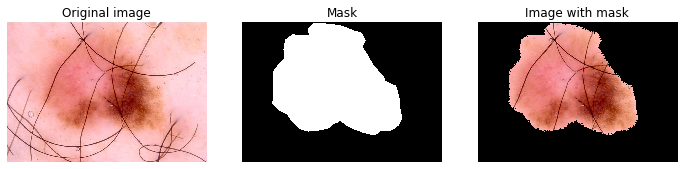

In [0]:
from skimage.io import imread
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid

# Choose a figure and plot it with the ground truth segmentation

indexIm=1


filename = listImages[indexIm]
im = imread(filename)
filename_Segmentation = filename[:-4] + '_Segmentation.png'

im_Seg = imread(filename_Segmentation) # Value 0 or 255
im_Seg_bool = (im_Seg/255).astype(np.uint8) # To get uint8
im_Seg_expand = np.expand_dims(im_Seg_bool, axis=2)
im_mul_mask = (im_Seg_expand*im) # pixel-wise product

fig = plt.figure(figsize=(12, 12))
grid = AxesGrid(fig, 111,
                nrows_ncols = (1, 3),
                axes_pad = 0.5)
grid[0].imshow(im)
grid[0].axis('off')
grid[0].set_title("Original image")
grid[1].imshow(im_Seg,cmap='gray')
grid[1].axis('off')
grid[1].set_title("Mask")
grid[2].imshow(im_mul_mask)
grid[2].axis('off')
grid[2].set_title("Image with mask")

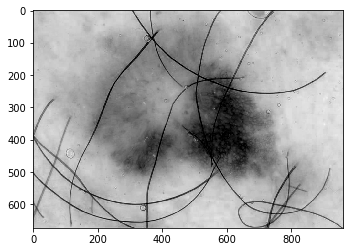

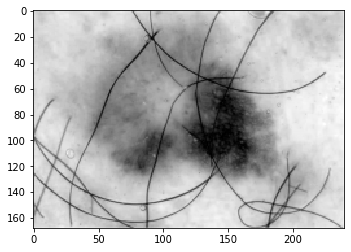

In [0]:
from skimage.transform import rescale
from skimage import img_as_bool

# We only select the blue channel to start
imb=im[:,:,2]
plt.figure()
plt.imshow(imb,cmap='gray')
plt.show()

# We rescale to speed up computations
imbr = np.uint8(rescale(imb, 0.25, anti_aliasing=True)*255)
im_Seg_r =  np.uint8(rescale(im_Seg, 0.25, anti_aliasing=True)*255) 
im_Seg_r_bool = (im_Seg_r/255).astype(np.uint8)

plt.figure()
plt.imshow(imbr,cmap='gray') 
plt.show()


Text(0.5, 1.0, 'Ground Truth Segmenation')

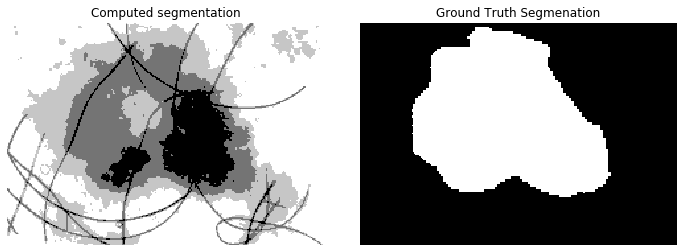

In [0]:

from sklearn.cluster import KMeans

Ncluster=4

x, y = imbr.shape
imFloat = np.array(imbr, dtype=np.float64) / 255 # transform into float for computational reason
kmeans = KMeans(n_clusters=Ncluster, n_jobs=-1) # use K-means algorithm 
kmeans.fit(imFloat.reshape(x*y,1)) # fit to the data reshapds as a 1D vector

cluster_centers = kmeans.cluster_centers_ # estimated centers
cluster_labels = kmeans.labels_ # estimated labels for each pixel

kmeansSeg = cluster_centers[cluster_labels].reshape(x, y) # reshaped as the original image
if Ncluster==2: # make kmeansSeg boolean
  kmeansSeg[kmeansSeg == max(kmeansSeg.flatten())] = 0  
  kmeansSeg[kmeansSeg == max(kmeansSeg.flatten())] = 1

fig = plt.figure(figsize=(12, 12))
grid = AxesGrid(fig, 111,
                nrows_ncols = (1, 2),
                axes_pad = 0.5)
grid[0].imshow(kmeansSeg,cmap='gray')
grid[0].axis('off')
grid[0].set_title("Computed segmentation")
grid[1].imshow(im_Seg_r_bool,cmap='gray')
grid[1].axis('off')
grid[1].set_title("Ground Truth Segmenation")

To quantitavely compare the two segmentations, we can use the Dice score defined as $DSC=\frac{2TP}{2TP+FP+FN}$ for boolean data. First, we should check that the computed segmentation mask is coherent with the ground truth

The dice similarity is  1.104792993910037
The dice similarity is  1.104792993910037


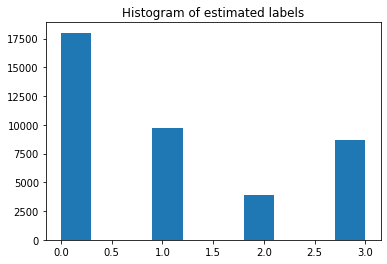

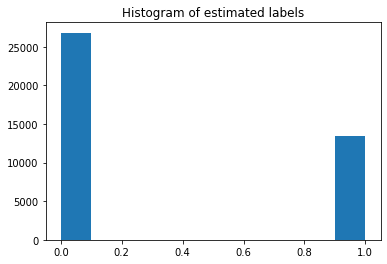

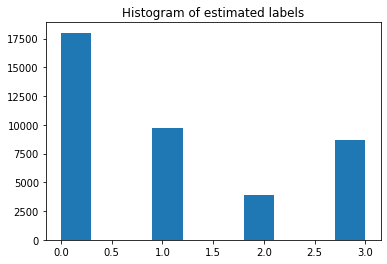

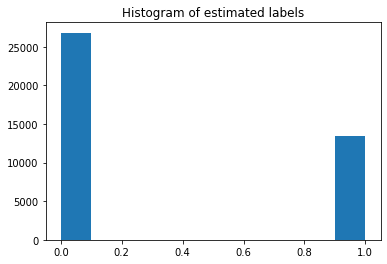

In [0]:
from scipy.spatial.distance import dice

plt.figure()
plt.hist(cluster_labels)
plt.title('Histogram of estimated labels')

plt.figure()
plt.hist(im_Seg_r_bool.flatten())
plt.title('Histogram of estimated labels')
from scipy.spatial.distance import dice

plt.figure()
plt.hist(cluster_labels)
plt.title('Histogram of estimated labels')

plt.figure()
plt.hist(im_Seg_r_bool.flatten())
plt.title('Histogram of estimated labels')

print('The dice similarity is ', 1-dice(cluster_labels,im_Seg_r_bool.flatten()))
print('The dice similarity is ', 1-dice(cluster_labels,im_Seg_r_bool.flatten()))


In [0]:
import skimage.morphology as morpho  

def strel(forme,taille,angle=45):
    """renvoie un element structurant de forme  
     'diamond'  boule de la norme 1 fermee de rayon taille
     'disk'     boule de la norme 2 fermee de rayon taille
     'square'   carre de cote taille (il vaut mieux utiliser taille=impair)
     'line'     segment de langueur taille et d'orientation angle (entre 0 et 180 en degres)
      (Cette fonction n'est pas standard dans python)
    """

    if forme == 'diamond':
        return morpho.selem.diamond(taille)
    if forme == 'disk':
        return morpho.selem.disk(taille)
    if forme == 'square':
        return morpho.selem.square(taille)
    if forme == 'line':
        angle=int(-np.round(angle))
        angle=angle%180
        angle=np.float32(angle)/180.0*np.pi
        x=int(np.round(np.cos(angle)*taille))
        y=int(np.round(np.sin(angle)*taille))
        if x**2+y**2 == 0:
            if abs(np.cos(angle))>abs(np.sin(angle)):
                x=int(np.sign(np.cos(angle)))
                y=0
            else:
                y=int(np.sign(np.sin(angle)))
                x=0
        rr,cc=morpho.selem.draw.line(0,0,y,x)
        rr=rr-rr.min()
        cc=cc-cc.min()
        img=np.zeros((rr.max()+1,cc.max()+1) )
        img[rr,cc]=1
        return img
    raise RuntimeError('Erreur dans fonction strel: forme incomprise')

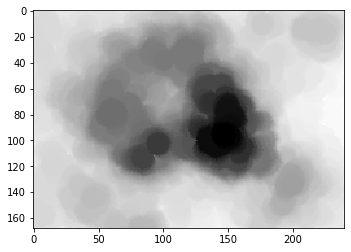

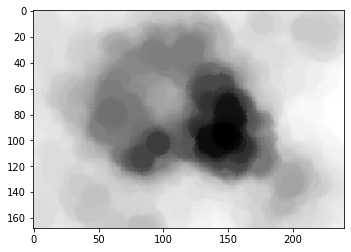

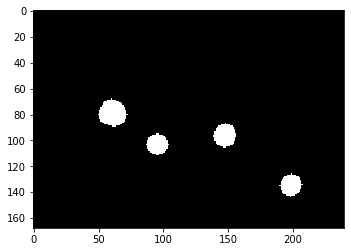

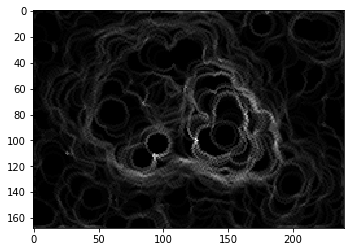

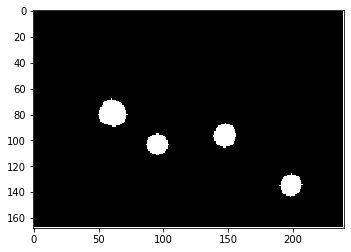

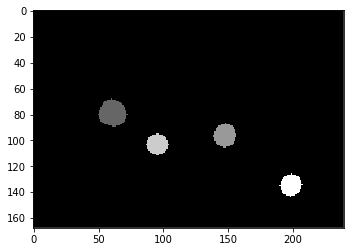

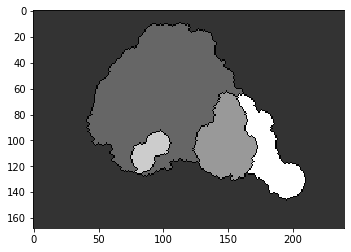

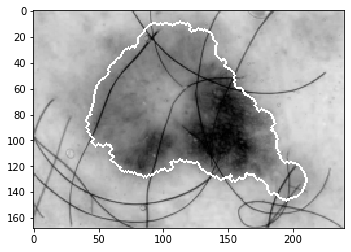

The dice similarity is  0.9185470763881014


In [0]:
#Travail
sizeDisque=8
disk=strel('disk',sizeDisque)
closeDisk=morpho.closing(imbr,disk)
plt.figure()
plt.imshow(closeDisk,cmap='gray')
plt.show()
N=3
se=strel('disk',N)
Open=morpho.opening(closeDisk,se)
plt.figure()
plt.imshow(Open,cmap='gray')
plt.show()


# Minima regionaux
maxIm=170
temp=Open.copy()
    
for i in range(Open.shape[0]):
    for j in range(Open.shape[1]):
        if Open[i,j] < maxIm: 
            temp[i,j]=Open[i,j]+1
reco=maxIm-morpho.reconstruction(maxIm-temp,maxIm-Open)
minReg=np.uint8(reco)-Open
plt.figure()
plt.imshow(minReg,cmap='gray')
plt.show()


from scipy import ndimage as ndi

#segmentation par ligne de partage des eaux avec marqueurs

#gradient morphologique de l'image initiale
se=morpho.selem.disk(1)
grad=morpho.dilation(closeDisk,se)-morpho.erosion(closeDisk,se)
plt.figure()
plt.imshow(grad,cmap='gray')
plt.show()

#suppression des marqueurs trop petits
tailleMin=5
seM=strel('disk',tailleMin)
minReg=morpho.opening(minReg,seM)

#ajout d'un marqueur sur le bord de l'image
for i in range(minReg.shape[0]):
    minReg[i,0]=1
    minReg[i,minReg.shape[1]-1]=1
for j in range(minReg.shape[1]):
    minReg[0,j]=1
    minReg[minReg.shape[0]-1,j]=1
    
plt.figure()
plt.imshow(minReg,cmap='gray')
plt.show()

markers = ndi.label(minReg)[0]
plt.figure()
plt.imshow(markers,cmap='gray')
plt.show()

labels = morpho.watershed(grad, markers,watershed_line=True)
plt.figure()
plt.imshow(labels,cmap='gray')
plt.show()

#%% visualiation du resultat

segm=labels.copy()
for i in range(segm.shape[0]):
    for j in range(segm.shape[1]):
        if segm[i,j] == 0: 
            segm[i,j]=255
        else:
            segm[i,j]=0
segm=ndi.binary_fill_holes(segm).astype(int)
#NB: ce resultat peut servir d'initialisation pour une autre methode de segmentation (croissance de regions, segmentation markovienne, etc.)

#superposition des contours de la segmentation a l'image initiale
contour=morpho.dilation(segm,se)-morpho.erosion(segm,se)
contourSup=np.maximum(contour*255,imbr)
plt.figure()
plt.imshow(contourSup,cmap='gray')
plt.show()       

print('The dice similarity is ', 1-dice(segm.flatten(),im_Seg_r_bool.flatten()))



pour le pipeline j'ai utilisé :
1_ une fermeture pour eliminer les poils (element structurant de tell sort sa langeur superieur a la largeur d'un poil)
2-une ouverture pour retirer les petites pièces brillantes

3_ detection des minimums regionaux (on change la valeur maxIm de tell sorte on detecte les minimum correspond au tache de lesion maxIm=170
cad si la valeur du minimum  superieur a 170 on le detecte pas)

4- watershed

cette pipeline ca marche pour l'image 1_3_4_ ...



Text(0.5, 1.0, 'image filtered')

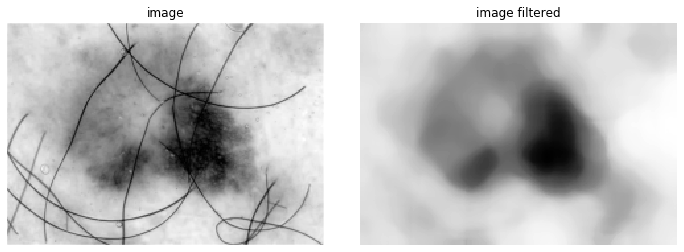

In [0]:
from scipy import ndimage

medianFilt = ndimage.median_filter(imbr, size=20)

fig = plt.figure(figsize=(12, 12))
grid = AxesGrid(fig, 111,
                nrows_ncols = (1, 2),
                axes_pad = 0.5)
grid[0].imshow(imbr,cmap='gray')
grid[0].axis('off')
grid[0].set_title("image")
grid[1].imshow(medianFilt,cmap='gray')
grid[1].axis('off')
grid[1].set_title("image filtered")


**Question**: Implement the original (or a modified version) of the DullRazor algorithm. If you modify the algorithm, please explain why. 

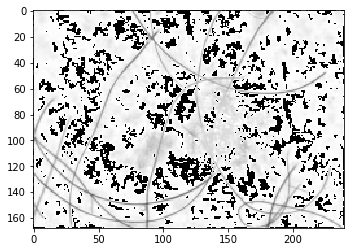

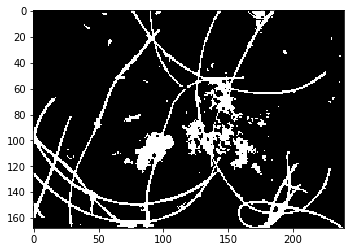

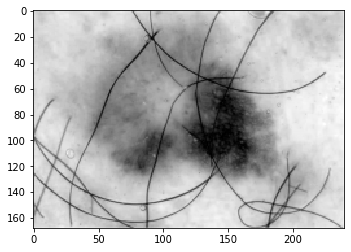

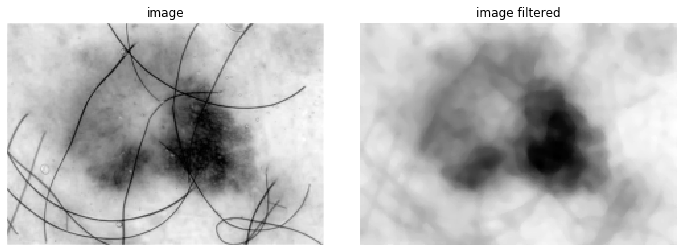

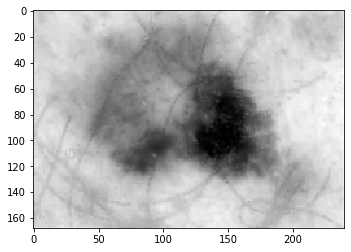

In [0]:
sizeDisque=10
disk=strel('disk',sizeDisque)
closeDisk=morpho.closing(imbr,disk)
plt.figure()
plt.imshow(imbr-closeDisk,cmap='gray')
plt.show()
res=(imbr-closeDisk)
(ii,jj)=np.shape(res)
for i in range (ii):
  for j in range (jj):
    if (res[i,j] < 40 or res[i,j] > 230):
      res[i,j]=0
    else:
      res[i,j]=255
#disk1=strel('disk',2)
#res=morpho.dilation(res,disk1)
plt.figure()
plt.imshow(res,cmap='gray')
plt.show()

plt.figure()
plt.imshow(imbr,cmap='gray')
plt.show()


from skimage.restoration import inpaint
image_result = inpaint.inpaint_biharmonic(imbr, res, multichannel=False)


from scipy import ndimage

medianFilt = ndimage.median_filter(image_result, size=6)

fig = plt.figure(figsize=(12, 12))
grid = AxesGrid(fig, 111,
                nrows_ncols = (1, 2),
                axes_pad = 0.5)
grid[0].imshow(imbr,cmap='gray')
grid[0].axis('off')
grid[0].set_title("image")
grid[1].imshow(medianFilt,cmap='gray')
grid[1].axis('off')
grid[1].set_title("image filtered")



plt.figure()
plt.imshow(image_result,cmap='gray')
plt.show()





Pour detecteR les poils j'ai calculer le chapeau haut de l'image
et puis j'ai fait un seuillage pour extraire le masque (rendre l'image binnaire) du poils 
qui prend des valeur intermediaire  
et appres on applique les deux autres fonction sur le masque 

OTSU algorithm

In [0]:
def Hist(img):
   row, col = img.shape 
   y = np.zeros(256)
   for i in range(0,row):
      for j in range(0,col):
         y[img[i,j]] += 1
   x = np.arange(0,256)
   plt.bar(x, y, color='b', width=5, align='center', alpha=0.25)
   plt.show()
   return y


def segmentation_otsu(img):

    min_sigma = np.float('inf')
    tau_out = 0
    min_level = 0.0
    max_level = 255.0
    n_levels = 256
    a,b=np.shape(img)
    nn=a*b
    y=Hist(img)
    for tau in range (0, 255,1):
        # first, get weights of the two regions
        omega_0 = np.sum(y[:tau])/nn
        omega_1 = np.sum(y[tau:])/nn
        
        # only analyse thresholds which give two non-empty regions
        if (omega_0!=0 and omega_1!=0 ):
            im0_ind=img<=tau
            m=np.mean(np.mean(img[im0_ind]))
            sigma_0 = 0
            ll=0
            for kk in img[im0_ind]:
              ll=ll+1
              sigma_0 += ((kk - m) **2) 
            if (ll!=0):
              sigma_0=sigma_0/ll
            

            im1_ind=img>tau
            m1=np.mean(np.mean((img[im1_ind])))
            sigma_1 =0
            ll=0
            for kk in img[im1_ind]:
              ll=ll+1
              sigma_1+= ((kk - m1) **2) 
            if (ll!=0):
              sigma_1=sigma_1/ll

            sigma_total = omega_0*sigma_0 + omega_1*sigma_1

            if (sigma_total < min_sigma):
                tau_out = tau
                min_sigma = sigma_total

    img_out = np.zeros((img.shape[0],img.shape[1]))
    img_out[img<tau_out] = 1
    return img_out,tau_out

You can apply the Otsu method to segment previously pre-processed images.

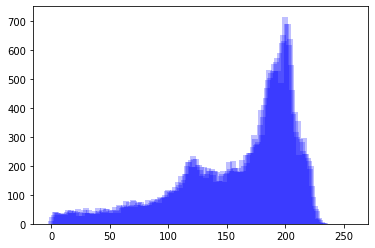

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


The best threshold is 142
The dice similarity is  0.835567505281352


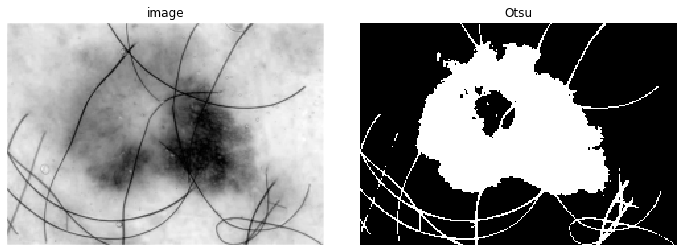

In [0]:
Otsu,tau = segmentation_otsu(imbr)

fig = plt.figure(figsize=(12, 12))
grid = AxesGrid(fig, 111,
                nrows_ncols = (1, 2),
                axes_pad = 0.5)
grid[0].imshow(imbr,cmap='gray')
grid[0].axis('off')
grid[0].set_title("image")
grid[1].imshow(Otsu,cmap='gray')
grid[1].axis('off')
grid[1].set_title("Otsu")

print('The best threshold is {}'.format(tau))
print('The dice similarity is ', 1-dice(Otsu.flatten(),im_Seg_r_bool.flatten()))


One of the problem of the Otsu method it's that there is no notion of connectivity (two regions far away can be in the same region). For such a notion, we turn to region merging.

## Region merging

The region merging algorithm is quite simple : we start with a small region, and add pixels progressively to the region, according to a criterion. We choose the following criterion :

- A pixel $p$ is added to the region if the absolute difference between the pixel value and the region's average value is less than a threshold value (which you must set).

First, we can create a function called ``initialize_segmentation`` which initialises the segmentation with a small circular region centred on a given seed point (the seed point is an input). For this, the following function :

- scipy.ndimage.morphology.distance_transform_edt

can be useful.

In [0]:
from scipy.ndimage.morphology import distance_transform_edt

def initialize_segmentation(seed_pt,img_shape):
    seg_init = np.zeros(img_shape).astype(float)
    seg_init[ seed_pt[0], 
    seed_pt[1]] = 1
    dist = distance_transform_edt(np.abs(1-seg_init))

    # initialise the seeded region with a certain radius
    size_radius = 5
    seg_init = dist < size_radius
    return seg_init

Now, we can create a function called ``segmentation_region_growing`` which carries out the region growing algorithm, with the criterion above, and which uses the ``initialize_segmentation`` function. Again, the functions from ``scipy.ndimage.morphology`` can be useful here.

In [0]:
from scipy.ndimage import binary_dilation

def segmentation_region_growing(img,seed_pt,tau):

    # define the neighbourhood (for instance 4-connected pixels)
    nbhood = np.asarray( [ [0,1,0],[1,1,1],[0,1,0]] )

    seg_init = initialize_segmentation(seed_pt,img.shape)
    seg_n_plus_1 = seg_init
    seg_n = np.zeros(seg_n_plus_1.shape)

    # loop while the region can still keep growing
    while( np.abs(seg_n_plus_1 != seg_n).sum() != 0):
        seg_n = seg_n_plus_1
        seg_n_plus_1 = binary_dilation(seg_n, structure=nbhood).astype(seg_n.dtype)
        # calculate average value
        avg = np.sum( img[seg_n>0] ) / ( float(seg_n.sum()))
        seg_n_plus_1 = np.logical_and( seg_n_plus_1 , np.abs( img-avg ) < tau)
        # do not lose previous points of the segmentation
        seg_n_plus_1 = np.logical_or( seg_n_plus_1 , seg_n)

    return seg_n,seg_init

81.92093253968137 117.26684027777779
The dice similarity is  0.6208235821341432


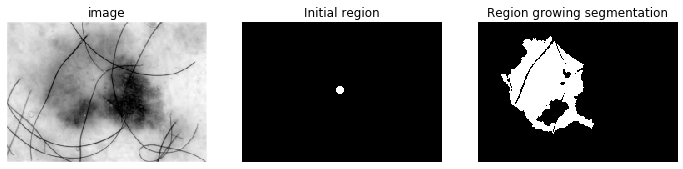

In [0]:
n,p=np.shape(labels)
imoy=0
jmoy=0
for i in range(n):
  for j in range(p):
    if  labels[i][j]!=0:
      imoy=imoy+i/(n*p)
      jmoy=jmoy+j/(n*p)
print(imoy,jmoy)
seed_pt = np.asarray([int(imoy),int(jmoy)])
tau=35
img_out_region_growing,seg_init = segmentation_region_growing(imbr,seed_pt,tau)

fig = plt.figure(figsize=(12, 12))
grid = AxesGrid(fig, 111,
                nrows_ncols = (1, 3),
                axes_pad = 0.5)
grid[0].imshow(imbr,cmap='gray')
grid[0].axis('off')
grid[0].set_title("image")
grid[1].imshow(seg_init,cmap='gray')
grid[1].axis('off')
grid[1].set_title("Initial region")
grid[2].imshow(img_out_region_growing,cmap='gray')
grid[2].axis('off')
grid[2].set_title("Region growing segmentation")

print('The dice similarity is ', 1-dice(img_out_region_growing.flatten(),im_Seg_r_bool.flatten()))


j'ai calculé le seed_point  on se basant sur le masque du premier pipeline , j'ai fais un moyenne des postions corresponds aux masque

# Graph-Cut
You can also use graph-cut, as seen in the previous lecture, to segment the image or to remove hair. You could, for instance, see the hair as noise and try to remove it using the gaussian model or the one of Potts.

Here, you can find an example of binary segmentation.

**Question**: propose a pipeline, based on graph-cuts and other pre-processing or post-processing methods, to correctly segment the images.

In [0]:
!pip install PyMaxflow
import maxflow

     |████████████████████████████████| 133kB 3.5MB/s 
  Created wheel for PyMaxflow: filename=PyMaxflow-1.2.12-cp36-cp36m-linux_x86_64.whl size=537288 sha256=1f2edf820fd9f32766b147f0f53f92bc6a174d9289ccacf6c9592078ae7b2e98
  Stored in directory: /root/.cache/pip/wheels/56/ab/a8/12b43e2024215b384364145b140e14a838b45ad39989f51a4f
Successfully built PyMaxflow


The dice similarity is  0.9086122302445251


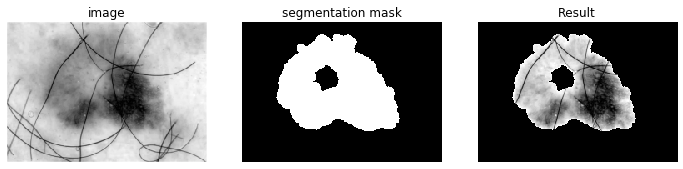

In [0]:
sizeDisque=5
disk=strel('disk',sizeDisque)
closeDisk=morpho.closing(imbr,disk)


Ncluster=2

x, y = closeDisk.shape
imFloat = np.array(closeDisk, dtype=np.float64) / 255 # transform into float for computational reason
kmeans = KMeans(n_clusters=Ncluster, n_jobs=-1) # use K-means algorithm 
kmeans.fit(imFloat.reshape(x*y,1)) # fit to the data reshapds as a 1D vector

cluster_centers = kmeans.cluster_centers_ # estimated centers
cluster_labels = kmeans.labels_

beta = 50

m1 = cluster_centers[1]*255
m2 = cluster_centers[0]*255

## Graph cut binaire

g = maxflow.Graph[float]()
nodeids = g.add_grid_nodes(closeDisk.shape)
g.add_grid_edges(nodeids, beta)
g.add_grid_tedges(nodeids, (closeDisk-m1)**2, (m2-closeDisk)**2)
flow = g.maxflow()
sgm = g.get_grid_segments(nodeids)
im_bin = 1 - np.int_(np.logical_not(sgm))

fig = plt.figure(figsize=(12, 12))
grid = AxesGrid(fig, 111,
                nrows_ncols = (1, 3),
                axes_pad = 0.5)
grid[0].imshow(imbr,cmap='gray')
grid[0].axis('off')
grid[0].set_title("image")
grid[1].imshow(im_bin,cmap='gray')
grid[1].axis('off')
grid[1].set_title("segmentation mask")
grid[2].imshow(imbr*im_bin,cmap='gray')
grid[2].axis('off')
grid[2].set_title("Result")

print('The dice similarity is ', 1-dice(im_bin.flatten(),im_Seg_r_bool.flatten()))

Pour ce probleme, j'ai utilisé une fermeture morphologique pour eliminer les poils suivie d'un kmeans pour detecter les deux centres multipliés par 255 pour trouver la valeur moyenne de m1 et m2, ensuite j'ai appliqué le graphcut sur l'image sans poils pour avoir un meilleur resultat , En conclusion les valeurs de m1 et m2 ne doivent pas etres constantes elles dependent des valeurs de pixels dans l'image ce qui fait la difference de l'indice de similarité allant de 0.4 à 0.9